In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [3]:
# Perform seasonal decomposition
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)  # Adjust period as needed

In [4]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [5]:
# ARIMA model
model = ARIMA(train['Close'], order=(5, 1, 0))
arima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [6]:
# Predictions
history = [x for x in train['Close']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Close'].iloc[t]
    history.append(obs)

In [7]:
# Evaluate ARIMA model
error = mean_squared_error(test['Close'], predictions)
print('ARIMA Mean Squared Error:', error)

ARIMA Mean Squared Error: 4.955165685426654


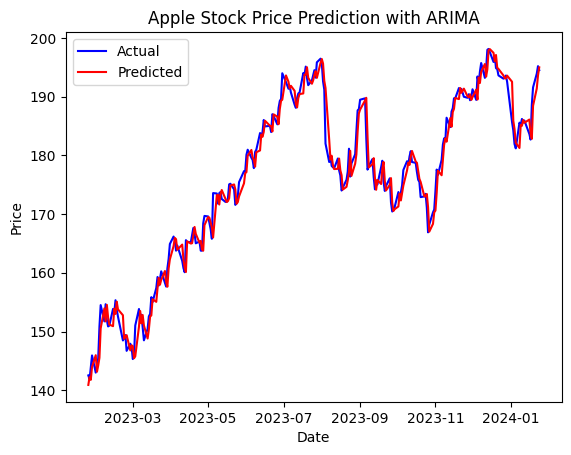

In [8]:
# Visualize predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()